<a href="https://colab.research.google.com/github/lefthandedcoder/plantclassifier/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wild Edible Plant Classification Notebook

## Kaggle Setup and Dataset Preparation

In [ ]:
! pip install kaggle

In [1]:
! mkdir ~/.kaggle

In [2]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download ryanpartridge01/wild-edible-plants/

 99% 1.69G/1.70G [00:15<00:00, 130MB/s]
100% 1.70G/1.70G [00:16<00:00, 114MB/s]


In [ ]:
! unzip wild-edible-plants.zip

## Dataset Distribution Bar Chart

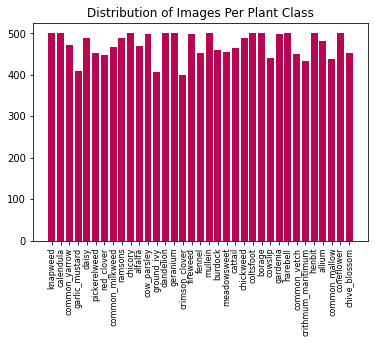

In [84]:
# Get bar chart of images per subdirectory
bar_classes = []

classes = ([name for name in os.listdir('/content/dataset/resized/')
            if os.path.isdir(os.path.join('/content/dataset/resized/', name))]) # get all directories 
for plant in classes:
    contents = os.listdir(os.path.join('/content/dataset/resized/', plant)) # get list of contents
    bar_classes.append([plant, len(contents)])

bar_classes = [['knapweed', 500],
              ['calendula', 500],
              ['common_yarrow', 473],
              ['garlic_mustard', 409],
              ['daisy', 490],
              ['pickerelweed', 454],
              ['red_clover', 449],
              ['common_milkweed', 467],
              ['ramsons', 489],
              ['chicory', 500],
              ['alfalfa', 470],
              ['cow_parsley', 499], 
              ['ground_ivy', 408],
              ['dandelion', 500],
              ['geranium', 500],
              ['crimson_clover', 400],
              ['fireweed', 499],
              ['fennel', 452],
              ['mullein', 500],
              ['burdock', 460],
              ['meadowsweet', 455],
              ['cattail', 466], 
              ['chickweed', 488],
              ['coltsfoot', 500],
              ['borage', 500],
              ['cowslip', 441],
              ['gardenia', 499],
              ['harebell', 500],
              ['common_vetch', 451],
              ['crithmum_maritimum', 433],
              ['henbit', 500], 
              ['allium', 481], 
              ['common_mallow', 439],
              ['coneflower', 500],
              ['chive_blossom', 454]]

labels, ys = zip(*bar_classes)
xs = np.arange(len(labels)) 
width = 1

col = (np.random.random(), np.random.random(), np.random.random())

fig = plt.figure()                                                               
ax = fig.gca()  #get current axes
ax.bar(xs, ys, color=col)

ax.set_title("Distribution of Images Per Plant Class")
ax.set_xticks(xs)
ax.set_xticklabels(labels, rotation = 90, fontsize = 8)

plt.savefig('distribution.png')

### Dataset Preparation with Train/Validation Subdirectory Splitting

In [167]:
!pip install split-folders tqdm
import splitfolders  # or import split_folders

# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
splitfolders.fixed("/content/dataset/resized", output="/content/dataset", seed=1337, fixed=(100), oversample=False, group_prefix=None) # default values


Copying files: 0 files [00:00, ? files/s]
Copying files: 359 files [00:00, 3579.00 files/s]
Copying files: 730 files [00:00, 3654.56 files/s]
Copying files: 1112 files [00:00, 3729.49 files/s]
Copying files: 1485 files [00:00, 3647.14 files/s]
Copying files: 1883 files [00:00, 3702.28 files/s]
Copying files: 2310 files [00:00, 3887.68 files/s]
Copying files: 2700 files [00:00, 3739.92 files/s]
Copying files: 3076 files [00:00, 3695.16 files/s]
Copying files: 3447 files [00:00, 3654.95 files/s]
Copying files: 3814 files [00:01, 3543.36 files/s]
Copying files: 4170 files [00:01, 3531.32 files/s]
Copying files: 4524 files [00:01, 3519.35 files/s]
Copying files: 4904 files [00:01, 3600.87 files/s]
Copying files: 5265 files [00:01, 3488.05 files/s]
Copying files: 5615 files [00:01, 2804.97 files/s]
Copying files: 5917 files [00:01, 2332.68 files/s]
Copying files: 6176 files [00:01, 2093.01 files/s]
Copying files: 6405 files [00:02, 2025.41 files/s]
Copying files: 6621 files [00:02, 1992.41

## Importing Python Libraries

In [85]:
#Import libraries
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Flatten, Activation, Dropout
from keras import backend as K
from keras.backend import expand_dims
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from PIL import Image
from keras.preprocessing.image import image
from google.colab import files
from IPython.display import Image

## Defining Constants

In [86]:
#Dimensions of images
IMG_WIDTH, IMG_HEIGHT = 224, 224
TRAIN_DATA_DIR = '/content/dataset/train'
VALIDATION_DATA_DIR = '/content/dataset/val'
NB_TRAIN_SAMPLES = 10000
NB_VALIDATION_SAMPLES = 2500
EPOCHS = 25
BATCH_SIZE = 32

## Image Preparation and Augmentation

Images are prepared for machine learning by ensuring that all images are in the necessary input shape. Images in the training set are augmented to improve training efficiency.

In [87]:
if K.image_data_format() == 'channels_first':
	input_shape = (3, IMG_WIDTH, IMG_HEIGHT)
else:
	input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

train_datagen = ImageDataGenerator(
	rescale = 1. / 255,
	shear_range = 0.2,
	zoom_range = 0.2,
	horizontal_flip = True)

# Augmentation configuration for testing:
test_datagen = ImageDataGenerator(rescale = 1. / 255)

train_generator = train_datagen.flow_from_directory(
	TRAIN_DATA_DIR,
	target_size = (IMG_WIDTH, IMG_HEIGHT),
	batch_size = BATCH_SIZE,
	class_mode = 'categorical')

validation_generator = train_datagen.flow_from_directory(
	VALIDATION_DATA_DIR,
	target_size = (IMG_WIDTH, IMG_HEIGHT),
	batch_size = BATCH_SIZE,
	class_mode = 'categorical')

Found 13026 images belonging to 35 classes.
Found 3500 images belonging to 35 classes.


### Visualization of Image Augmentation and Preparation

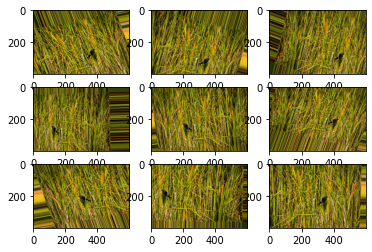

Found 16526 images belonging to 35 classes.


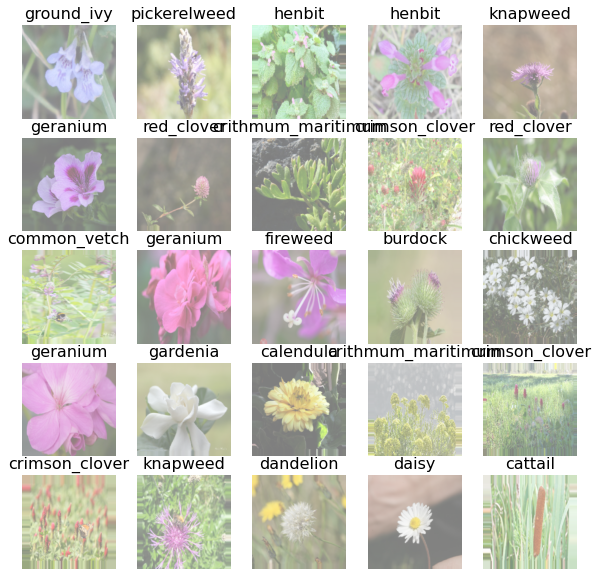

In [113]:
# load sample image
img = keras.preprocessing.image.load_img('/content/dataset/resized/cattail/cattail150.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range = 0.2,
    height_shift_range= 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  # plot raw pixel data
  plt.imshow(image)
# show the figure
plt.show()
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/resized/',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=123,
    class_mode='categorical',
    subset='training') # set as training data
# Sample of images from dataset
class_dict = train_generator.class_indices
new_dict={}
for key, value in class_dict.items():
    new_dict[value] = key        
images,labels = next(train_generator) # sample batch from generator
plt.figure(figsize = (10, 10))
length = len(labels)
if length < 25:   #show maximum of 25 images
    r = length
else:
    r = 25
for i in range(r):
    plt.subplot(5, 5, i + 1)
    image = (images[i]+1 )/2
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name = new_dict[index]
    plt.title(class_name, fontsize=16)
    plt.axis('off')
plt.show()

## Building the Machine Learning Model with Transfer Learning

In [107]:
tf.get_logger().setLevel('ERROR')
base_model= tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', name='fci')(x)
x = Dropout(0.5)(x)

predictions = Dense(35, activation='softmax', name='predictions')(x)

model = Model(base_model.input, predictions)

for layer in base_model.layers:
        layer.trainable = False

model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

9420800/9406464 [==============================] - 0s 0us/step


## Training the Machine Learning Model

In [108]:
filepath="/content/drive/MyDrive/weights.best.hdf5"

red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1)
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_accuracy', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')
callbacks_list = [checkpoint, red_lr]

history = model.fit(
	train_generator,
	steps_per_epoch = NB_TRAIN_SAMPLES // BATCH_SIZE,
	epochs = EPOCHS,
	validation_data = validation_generator,
	validation_steps = NB_VALIDATION_SAMPLES // BATCH_SIZE,
  callbacks = callbacks_list)

model.save_weights('/content/drive/MyDrive/ediblemodel.h5')

Epoch 1/25
312/312 [==============================] - 260s 823ms/step - loss: 1.5510 - accuracy: 0.5650 - val_loss: 0.8409 - val_accuracy: 0.7488

Epoch 00001: val_accuracy improved from -inf to 0.74880, saving model to /content/drive/MyDrive/weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
312/312 [==============================] - 256s 819ms/step - loss: 0.9764 - accuracy: 0.7116 - val_loss: 0.6625 - val_accuracy: 0.8065

Epoch 00002: val_accuracy improved from 0.74880 to 0.80649, saving model to /content/drive/MyDrive/weights.best.hdf5
Epoch 3/25
312/312 [==============================] - 259s 829ms/step - loss: 0.8752 - accuracy: 0.7411 - val_loss: 0.5830 - val_accuracy: 0.8249

Epoch 00003: val_accuracy improved from 0.80649 to 0.82492, saving model to /content/drive/MyDrive/weights.best.hdf5
Epoch 4/25
312/312 [==============================] - 251s 804ms/step - loss: 0.8094 - accuracy: 0.7572 - val_loss: 0.5551 - val_accuracy: 0.8321

Epoch 00004: val_accuracy improved from 0.82492 to 0.83213, saving model to /content/drive/MyDrive/weights.best.hdf5
Epoch 5/25
312/312 [==============================] - 241s 773ms/step - loss: 0.7524 - accuracy: 0.7732 - val_loss: 0.5300 - val_accuracy: 0.8341

Epoch 00005: val_accuracy improved from 0.83213 to 0.83413, s

## Visualization of Model Accuracy and Loss

In [160]:
def plot_accuracy():
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
def plot_loss():
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  val_loss, val_acc = model.evaluate(validation_generator, steps=50)
  print('Validation accuracy:', val_acc)

## Training in Blue, Validation in Orange

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


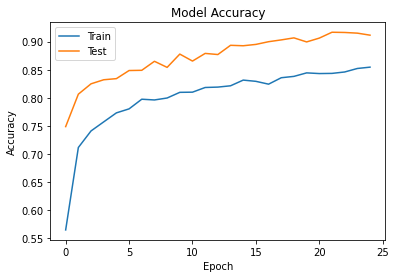

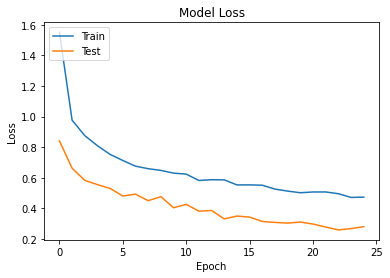

50/50 [==============================] - 33s 633ms/step - loss: 0.2883 - accuracy: 0.9044
Validation accuracy: 0.9043750166893005


In [161]:
plot_accuracy()
plot_loss()

## Model Deployment

### Uploading the Model

In [156]:
def model_setup():
  print('Please upload the machine learning model.')
  upload_model = files.upload()
  user_model = next(iter(upload_model))

Please upload the machine learning model.


Saving weights.best.hdf5 to weights.best.hdf5


### Uploading and Classifying Images

In [165]:
def image_app():
  print('\nPlease select an image for classification.\n')
  uploaded = files.upload()
  filename = next(iter(uploaded))
  #filename = '/content/allium.jpg'
  img_pred = keras.preprocessing.image.load_img(filename, target_size= (224, 224))
  img_pred = keras.preprocessing.image.img_to_array(img_pred)/255.
  img_pred = keras.backend.expand_dims(img_pred, axis = 0)

  ##### Test model
  model = load_model(filepath)
  rslt = model.predict(img_pred)
  y = round(rslt[0][np.argmax(rslt)], 2)
  confidence = y * 100

  preds_classes = np.argmax(rslt, axis=-1)

  plant_classes = ['alfalfa', 
                  'allium', 
                  'borage', 
                  'burdock', 
                  'calendula', 
                  'cattail', 
                  'chickweed', 
                  'chicory', 
                  'chive_blossom', 
                  'coltsfoot', 
                  'common_mallow', 
                  'common_milkweed', 
                  'common_vetch', 
                  'common_yarrow', 
                  'coneflower', 
                  'cow_parsley', 
                  'cowslip', 
                  'crimson_clover', 
                  'crithmum_maritimum', 
                  'daisy',
                  'dandelion', 
                  'fennel', 
                  'fireweed', 
                  'gardenia', 
                  'garlic_mustard', 
                  'geranium', 
                  'ground_ivy', 
                  'harebell', 
                  'henbit', 
                  'knapweed', 
                  'meadowsweet', 
                  'mullein', 
                  'pickerelweed', 
                  'ramsons', 
                  'red_clover']

  score = tf.nn.softmax(rslt[0])

  display(Image(filename, width = 150, height = 150))
  print(
      "\nThis is most likely an image of the wild edible plant {0} with a confidence of {1}%."
      .format(plant_classes[np.argmax(score)], confidence.round(2))
      )

# **Upload Image Below for Classification**

In [ ]:
model_setup()

In [ ]:
image_app()